<a href="https://colab.research.google.com/github/callumhedemann/Reinforcement-Learning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning: Value Function Methods

This notebook contains implementations of the following value function aproximation algorithms:

Tabular Algorithms:
- Tabular Q-learning - TD(0)
- Tabular N-Step SARSA
- Tabular TD(Lambda) - Eligibilty Traces


Value Function Approximation Algorithms:

Linear Value Function Approximation Algorithms:
- Mountain Car with Tile Codings

Non-Linear Function Approximation - the Deadly Triad:
- Cartpole with ANN, Experience Replay and Double DQN
- Mountain Car with ANN, Prioritised Experience Replay and DDQN (UNSOLVED)
- Cartpole with CNNs, Experience Replay, Target Networls and DDQN


(Note: Each cell is designed to run independently, which is why code is often repeated)

### Tabular Q-learning - TD(0): Slippery Frozen Lake 8x8

CPU times: user 4min 43s, sys: 96.8 ms, total: 4min 43s
Wall time: 4min 44s


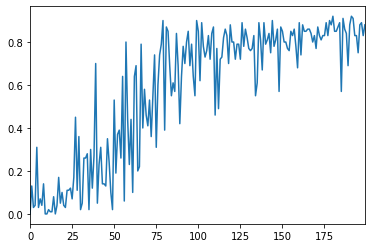

In [0]:
%%time

import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake8x8-v0', is_slippery=True)

def rate_policy(env, policy, n_episodes=100):    
    wins = 0
    for _ in range(n_episodes):
        env.reset()
        state = 0
        while True:
            action = np.argmax(policy[state])
            state, reward, done, _ = env.step(action)
            if done:
                if reward==1:
                    wins+=1
                break
    return wins/n_episodes

q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min = 1.0, 0.1
epsilon_max, epsilon_min = 0.9, 0.1
gamma = 0.99
n_episodes = 200000
avg_wins = []
# q-learning because next action = argmax_a q(s,a)
for n in range(n_episodes):
    env.reset()
    state = 0
    if n < (n_episodes/2): # decreasing linear schedules   
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min 
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min
    while True:
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] * (1-int(done)) - q_sa)
        state = observation        
        if done: 
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
pd.Series(avg_wins).plot()

### N-step Tabular Sarsa

##### Monte Carlo (high n values) require lower learning rates

first win


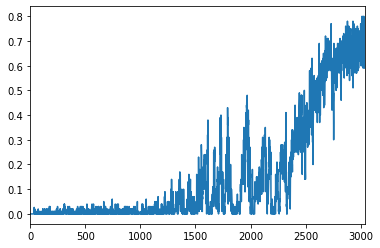

In [0]:
#%%time
import gym
import time, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
env = gym.make('FrozenLake8x8-v0', is_slippery=True)

q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.1, 0.01, 0.99, 0.5, 0.1
n_episodes = 300000
wins, avg_wins = [], []
avg_wins_freq = 100
nstep = 100 # n step sarsa
first_win = False

# what about first visit vs every visit updates???

for n in range(n_episodes):
    env.reset()    
    states, actions, rewards = [0], [], [] # epsiode trajectory    
    t, T = 0, np.inf
    done = False
    win = 0.0    
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule       
    while True:
        #alpha, epsilon = 1.0, 0.9
        if not first_win: # don't start coutning episodes until a win has been round at random
            n = 0
            epsilon = 1.0

        if not done:
            if (random.random() < epsilon):
                action = env.action_space.sample()
            else:
                action = np.argmax(q_values[states[-1]])
            observation, reward, done, _ = env.step(action)
            states.append(observation)
            actions.append(action)
            rewards.append(reward)
            if reward==1 and not first_win:
                first_win = True
                print('first win')
            if reward==1:
                win = 1.0
        tau = t - nstep + 1

        #if win and tau>=0:
        #    #print(q_values)
        #    print('states', states)#[-10:])
        #    print('actions', actions)#[-10:])
        #    print('t,T',t,T)
        #    print('tau', tau)
        if tau >= 0: # update operation at step tau
            g, gam = 0, 1
            #if win and tau>=0:
            #    print('rewards', rewards[tau:min(tau+nstep,T+1)])
            for r in rewards[tau:min(tau+nstep,T+1)]: # the sample estimate of rewards                
                g += gam*r
                gam *= gamma
            #if win and tau>=0:
            #    print('g sam',g)
            if (tau+nstep) < T:  # the bootstrap estimate of q_s'a'
                g += (gamma**nstep) * q_values[states[tau+nstep], np.argmax(q_values[states[tau+nstep]])]
                #if win and tau>=0:
                #    print('g bs',g)
            q_sa = q_values[states[tau], actions[tau]]
            q_values[states[tau], actions[tau]] = q_sa + alpha * (g - q_sa)                                   

            # this is bad,it doesnt work like this:
            # if (T - tau) < nstep: # stop updating if remaining trajectory is less than nstep
            #    asdasd
            #    break

        if done and T == np.inf:
            T = t        
        #if win and tau>=0:
        #    print(q_values)
        #    print('-------------------\n')                
        if tau >= T:
            break    
        t+=1
    wins.append(win)
    if n%avg_wins_freq==0: # diagnostic
        avg_wins.append(np.mean(wins[-avg_wins_freq:]))
#env.close()
pd.Series(avg_wins).plot()

### An alternate implementation of the same algorithm

CPU times: user 4min 59s, sys: 206 ms, total: 4min 59s
Wall time: 5min


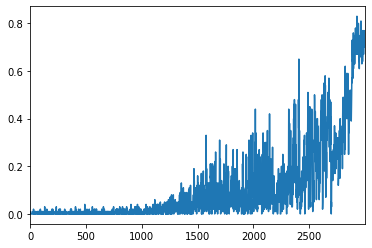

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.9, 0.9, 0.1
n_episodes = 300000
wins, avg_wins = [], []
avg_wins_freq = 100
nstep = 5 # n step sarsa, or n td(n) ??
for n in range(n_episodes):
    env.reset()
    state = 0
    states,actions,rewards = [0], [], [] # epsiode trajectory
    win = 0.0    
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 1.0, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, _ = env.step(action)
        states.append(observation)        
        actions.append(action)
        rewards.append(reward)
        if reward == 1:
            win = 1.0        
        if len(states)>nstep: # update operation        
            g, gam = 0, 1
            for r in rewards[-nstep:]: # the sample estimate of rewards
                g += gam*r
                gam *= gamma            
            g += (gamma ** nstep) * q_values[observation, np.argmax(q_values[observation])] # the bootstrap estimate of q_s'a'            
            q_sa = q_values[states[-(nstep+1)], actions[-nstep]]                    
            q_values[states[-(nstep+1)], actions[-nstep]] = q_sa + alpha * (g - q_sa)
        state = observation                
        if done: # finish remaining updates with trajectory length < nstep
            for i in range(min(nstep,len(states)-1)):
                g, gam = 0, 1
                for r in rewards[-i:]: # the sample estimate of rewards
                    g += gam*r
                    gam *= gamma            
                # no bootstrapping required as full return is known by this point
                q_sa = q_values[states[-(i+1)], actions[-i]]                    
                q_values[states[-(i+1)], actions[-i]] = q_sa + alpha * (g - q_sa)
            #if reward==1:
            #    print('win')
            wins.append(win)
            break
    if n%avg_wins_freq==0: # diagnostic
        avg_wins.append(np.mean(wins[-avg_wins_freq:]))
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 4min 5s, sys: 222 ms, total: 4min 5s
Wall time: 4min 5s


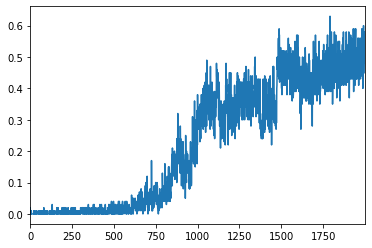

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = .01, 0.001, 0.9, 0.9, 0.1
# longer returns do not work with high learning rates - lr must be lowered for longer returns
n_episodes = 200000
wins, avg_wins = [], []
avg_wins_freq = 100
nstep = 100 # n step sarsa, or n td(n) ??
for n in range(n_episodes):
    env.reset()
    state = 0
    states,actions,rewards = [0], [], [] # epsiode trajectory
    win = 0.0    
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 1.0, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, _ = env.step(action)
        states.append(observation)        
        actions.append(action)
        rewards.append(reward)
        if reward == 1:
            win = 1.0        
        if len(states)>nstep: # update operation        
            g, gam = 0, 1
            for r in rewards[-nstep:]: # the sample estimate of rewards
                g += gam*r
                gam *= gamma            
            g += (gamma ** nstep) * q_values[observation, np.argmax(q_values[observation])] # the bootstrap estimate of q_s'a'            
            q_sa = q_values[states[-(nstep+1)], actions[-nstep]]                    
            q_values[states[-(nstep+1)], actions[-nstep]] = q_sa + alpha * (g - q_sa)
        state = observation                
        if done: # finish remaining updates with trajectory length < nstep
            for i in range(min(nstep,len(states)-1)):
                g, gam = 0, 1
                for r in rewards[-i:]: # the sample estimate of rewards
                    g += gam*r
                    gam *= gamma            
                # no bootstrapping required as full return is known by this point
                q_sa = q_values[states[-(i+1)], actions[-i]]                    
                q_values[states[-(i+1)], actions[-i]] = q_sa + alpha * (g - q_sa)
            #if reward==1:
            #    print('win')
            wins.append(win)
            break
    if n%avg_wins_freq==0: # diagnostic
        avg_wins.append(np.mean(wins[-avg_wins_freq:]))
#env.close()
pd.Series(avg_wins).plot()

## Eligibility Traces: Lambda Returns

#### TD(lambda=0)

CPU times: user 5min 38s, sys: 75.9 ms, total: 5min 38s
Wall time: 5min 38s


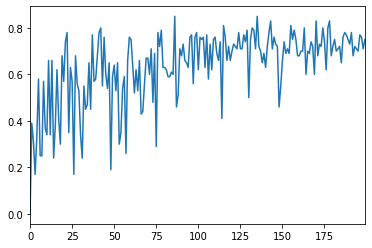

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.9, 0.1
n_episodes = 200000
trace_decay = 0.0 #  0 := TD(0);     1 := Monte Carlo
avg_wins = []
for n in range(n_episodes):
    env.reset()
    state = 0
    traces = np.zeros((env.observation_space.n, env.action_space.n))
    #states, actions = [], []
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 0.1, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation
        traces[state, action] += 1 # or = 1? this choice is called accumulating traces vs replacing traces
        td_error = reward + gamma * q_values[observation, np.argmax(q_values[observation])] * (1-int(done)) - q_values[state, action]        
        #if reward==1:
        #  print('1', td_error)
        # apply q value update as matrix opertion where td_error is broadcast across entire matrix
        q_values += alpha * td_error * traces              
        traces *= gamma * trace_decay        
        #traces[traces<0.01] = 0 # truncate traces (not needed in episodic)
        state = observation
        if done: 
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

#### TD(lambda-0.99) 





CPU times: user 4min 31s, sys: 54.9 ms, total: 4min 32s
Wall time: 4min 32s


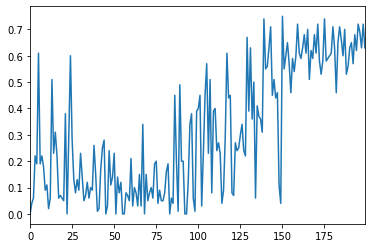

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.9, 0.1
n_episodes = 200000
trace_decay = 0.99 #  0 := TD(0);     1 := Monte Carlo
avg_wins = []
for n in range(n_episodes):
    env.reset()
    state = 0
    traces = np.zeros((env.observation_space.n, env.action_space.n))
    #states, actions = [], []
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 0.1, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation
        # note: need to set to replacing traces in order to make longer returns work:
        traces[state, action] = 1 # or = 1? this choice is called accumulating traces vs replacing traces
        td_error = reward + gamma * q_values[observation, np.argmax(q_values[observation])] * (1-int(done)) - q_values[state, action]        
        #if reward==1:
        #  print('1', td_error)
        # apply q value update as matrix opertion where td_error is broadcast across entire matrix
        q_values += alpha * td_error * traces              
        traces *= gamma * trace_decay        
        #traces[traces<0.01] = 0 # truncate traces (not needed in episodic)
        state = observation
        if done: 
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

## Value Function Approximation

In [0]:
# for state spaces of intractable size

# q is now a function of state and a feature vector w:
# S * R^d -> R

# the prediction objective minimises MSE across the state distribution mew
# MSE aka mean(Value Error) := sum[mew(s) * (v(s) - v_hat(s))] ** 2
# (mew gives the weighted average)
# calculate state distribution as fraction of time spent under s

# optimise using SGD
# choose dimensionality of w (hidden size?)
# update operation:
# w_t+1 = w_t - 1/2 * alpha * grad[v(s) - v_hat(s, w_t)] ** 2
#       = w_t + alpha[v(s) - v_hat(s, w_t)] * grad(v_hat(s, w)_t)
# where grad of v_hat is a vector of partial derivitatives wrt to w

# Interesting and unique to RL:
# v(s) is unknown! 
# optimisation is done against an approximation of v(s), U_t(s) ("supervised")
# and so...  w_t+1 = w_t + alpha[U_t(s) - v_hat(s, w_t)] * grad(v_hat(s, w)_t)
# if U_t is an unbiased estimate of v(s) then it is guaranteed to converge to a local optimum under decreasing alpha

# but how is the approximation U_t(s) learned? it is not, because it is sampled.

# MC estimates of v are unbiased, so convergence is guaranteed

# Bootstrapped estimates have no such guarantees due to biases. 
# Since their estimates depend on w_t they will be biased and will not produce true gradient descent methods
# they only take part of the gradient into account: the part that effects w_t but not the target estimate
# which is why they are called semi-gradient methods
# they do not coverge reliably / robustly
# but fortunately they do in linear cases of w, and are faster learning than true gradient methods, can be online

### Linear Function Approximation

In [0]:
# weight vector and state vector are both of dimensionality d and v(s,w) is the linear combination of their product
# v(s,w) = w^T x(s) = sum(w_i * x_i)
# the features x_i form a set of basis functions that describe the feature space
# and because of the linearity, grad v = x(s)
# and therefore the update is simply w_t+1 = w_t + alpha[U_t - v_hat(s, w)] x(s)

# advantages of linear methods:
# convergence guaranteed
# global optimum or equally good local optimum can be found - or rather a point near it can be converged to

# Linear Semi-gradient TD(0)
# w_t+1 = w_t + alpha * (r + gamma * w^T * x_t+1 - w^T * x_t) * x_t

# an additional challenge of intractably large state spaces is that the next state | a is not given
# and so this must be approximated ?
# MountainCar gives state updates though, as:
# position x_t+1 = x_t + v_t+1
# velocity v_t+1 = v_t + 0.001 * a_t - 0.0025 cos(3x_t)
# where a0 = -1, a1 = 0, a2 = 1

#### Mountain Car with Tile Coding for linear features

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


CPU times: user 4min 53s, sys: 82 ms, total: 4min 54s
Wall time: 4min 54s


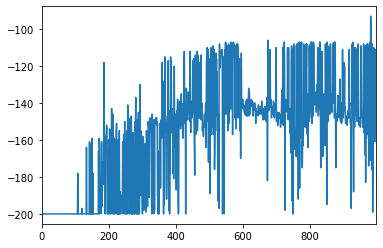

In [0]:
%%time
env = gym.make('MountainCar-v0')
# On-policy episodic semi-gradient one-step sarsa ???

# Linear Semi-gradient TD(0)
# w_t+1 = w_t + alpha * (r + gamma * w^T * x_t+1 - w^T * x_t) * x_t

# only have 2 features to work with?..
# need to create a state function which expands the state space into a latent feature space
# they use 8 grid tiliings (fig 9.9)
# but how does this help without non-linearities?
# note: not solvable with only 2 features directly from state? 
# oh, only true with linear methods

# https://towardsdatascience.com/reinforcement-learning-tile-coding-implementation-7974b600762b

def create_tiling(feat_range, bins, offset):    
    return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset
    
def create_tilings(feature_ranges, number_tilings, bins, offsets):
        tilings = []
        # for each tiling
        for tile_i in range(number_tilings):
            tiling_bin = bins[tile_i]
            tiling_offset = offsets[tile_i]
            tiling = []
            # for each feature dimension
            for feat_i in range(len(feature_ranges)):
                feat_range = feature_ranges[feat_i]
                # tiling for 1 feature
                feat_tiling = create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
                tiling.append(feat_tiling)
            tilings.append(tiling)
        return np.array(tilings)

"""
self.state = (position, velocity)
self.min_position = -1.2
self.max_position = 0.6
self.max_speed = 0.07
"""

num_features = 2
feature_ranges = [[-1.2, 0.6], [-0.07, 0.07]] # four dimensional feature space
number_tilings = 8
gs = 8
bins = [[gs, gs], [gs, gs], [gs, gs], [gs, gs],
        [gs, gs], [gs, gs], [gs, gs], [gs, gs]]
#offsets = [[-0.4, -0.1], # use asymettrical offsets
#           [-0.2, -0.05],
#           [0.1, 0.1],
#           [0.3, 0.15],
offsets = [[-0.2, -0.03], # use asymettrical offsets
           [-0.15, -0.02],
           [-0.1, -0.01],
           [-0.05, 0.0],
           [0.05, 0.01], # use asymettrical offsets
           [0.1, 0.02],
           [0.15, 0.03],
           [0.2, 0.04]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

def get_tile_coding(feature, tilings):
        num_dims = len(feature)
        feat_codings = []
        for tiling in tilings:
            feat_coding = []
            for i in range(num_dims):
                feat_i = feature[i]
                tiling_i = tiling[i]  # tiling on that dimension
                coding_i = np.digitize(feat_i, tiling_i)
                feat_coding.append(coding_i)
            feat_codings.append(feat_coding)
        return np.array(feat_codings)

def features(state):
    coding = get_tile_coding(state, tilings) # number_tilings sets of num_features d coords, 1 for each grid
    #print(coding)
    oh = np.zeros((number_tilings, gs, gs)) # number_tilings gs x gs grids of number_tilings d space    
    for i, row in enumerate(coding):        
        oh[tuple(np.append([i], row))] = 1 # tricky!
    #oh_a = np.zeros(env.action_space.n)
    #oh_a[a] = 1
    #return np.concatenate([oh.flatten(), oh_a])
    return oh.flatten()

# thanks to https://github.com/SamKirkiles/mountain-car-SARSA-AC/blob/master/mountain_car.py
# for pointing out that there is a seperate set of weights for each action
w = np.zeros((env.action_space.n, number_tilings*(gs**num_features)))

def q_value(state, action):
    return np.sum(w[action] * features(state))

# I think you are supposed to approximate the q values as well.
# https://stackoverflow.com/questions/53077399/when-using-functional-approximation-in-reinforcement-learning-how-does-one-selec
# this would mean action would have to be an input to q approx??
# "When choosing what action to select you enter the state and action into the neural net and get back the neural net's approximate values of each action."
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.1, 0.0
gamma = 0.99
n_episodes = 1000
returns = []
for n in range(n_episodes):
    state = env.reset()
    g = 0
    while True:
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min
        #alpha, epsilon = 0.1/number_tilings, 0.1
        alpha = 0.1/number_tilings
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            q_values = np.zeros(env.action_space.n)
            for i in range(env.action_space.n):
                q_values[i] = q_value(state, i)
            action = np.argmax(q_values)
        observation, reward, done, info = env.step(action)
        g += reward
        # update operation
        q_values = np.zeros(env.action_space.n)
        for i in range(env.action_space.n):
            q_values[i] = q_value(observation, i)
        next_action = np.argmax(q_values)        
        w[action] += alpha * (reward + gamma * q_value(observation, next_action) * (1-int(done)) - q_value(state, action)) * features(state) #SGD        
        if done:
            returns.append(g)
            break
        state = observation
pd.Series(returns).plot()

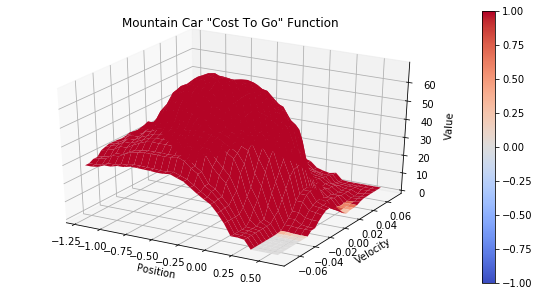

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def plot_cost_to_go_mountain_car(num_tiles=30):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda s: -np.max([q_value(s,a) for a in range(env.action_space.n)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain Car \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()

plot_cost_to_go_mountain_car()

## Non-linear Function Approximation

### The Deadly Triad: CartPole with ANN for Non-Linear Q function

#### Requires Experience Replay and Double DQN learning to overcome divergence in deadly triad

In [0]:
# the solutions to the q functions for these prolems are all non-linear
# using the raw features from the state to dot product with a weight vector is severely limiting in
# what linear function can be used to approximate the nonlinear q function
# using linear approximation requires feature engineering tricks to approximate these non-linearities with 
# many linear functions
# tile coding provides a mechanism to fit a large number of stepped constant functions
# as the states move through the space, they use an approximation for that immediate local region

# it would be much simpler / effective to just use a non-linear function 
# tile coding, or any other feature engineering methods, requires manual setup, tuning 
# and suffers from all the regular problems of manual feature engineering (suboptimal feature construction)
# and are not really appropriate approximation methods

# so now we just use a simple CNN to perform advanced feature engineering and fit a non-linear q function

episode  0
episode  25
episode  50
episode  75
episode  100
episode  125
episode  150
episode  175
episode  200
episode  225
episode  250
episode  275
episode  300
episode  325
episode  350
episode  375
episode  400
episode  425
episode  450
episode  475
episode  500
episode  525
episode  550
episode  575
episode  600
episode  625
episode  650
episode  675
episode  700
episode  725
episode  750
episode  775
episode  800
episode  825
episode  850
episode  875
episode  900
episode  925
episode  950
episode  975
episode  1000
episode  1025
episode  1050
episode  1075
episode  1100
episode  1125
episode  1150
episode  1175
episode  1200
episode  1225
episode  1250
episode  1275
episode  1300
episode  1325
episode  1350
episode  1375
episode  1400
episode  1425
episode  1450
episode  1475
episode  1500
episode  1525
episode  1550
episode  1575
episode  1600
episode  1625
episode  1650
episode  1675
episode  1700
episode  1725
episode  1750
episode  1775
episode  1800
episode  1825
episode  

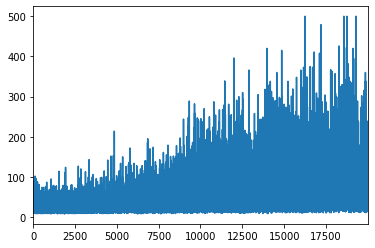

In [0]:
#%%time
# CNN seems to be too hard, try using a shallow NN using the raw state as features, the non linearaity should be able to do what the linear could not with them

# deadly triad??
# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

import gym
import random
import numpy as np
import pandas as pd
env = gym.make('CartPole-v1')
import torch
import torch.nn as nn
import torch.nn.functional as F


class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=256):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = torch.tanh(self.fc1(x)) # https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html, https://github.com/DavidSanwald/DDQNz
        #x = torch.tanh(self.fc2(x)) # for reals tanh over rulu makes this thing work???
        return self.out(x)

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# https://colab.research.google.com/drive/13Q3nTOJY9vYbhg1C0aXXIVM-IQaVVSaU#scrollTo=x--uPzWVHWPU
q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
#optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
optimiser = torch.optim.Adam(q_function.parameters(), lr=0.01)
buffer = ReplayBuffer()
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.2, 0.01, 0.9, 0.1
gamma = torch.Tensor([0.9]).cuda()
n_episodes = 20000
bs = 64
target_update = 10
returns, avg_returns, losses = [], [], []
avg_returns_freq = 25

for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        
        #alpha = 0.01
        #epsilon = 0.1

        #for param_group in optimiser.param_groups:
        #    param_group['lr'] = alpha
                
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0))
        
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values.squeeze()).item()         
        
        observation, reward, done, _ = env.step(action)
        observation = torch.Tensor(observation).cuda()        
        
        buffer.push(state, action, reward, observation, 1-int(done)) # sars
        g += reward

        if (len(buffer) >= bs): # and (frame_num%(bs*frame_skip)==0):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]), torch.Tensor(batch[4]).cuda()
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            #actions_mask = torch.zeros((bs,env.action_space.n))
            #actions_mask[np.arange(bs), actions] = 1

            # update operation
            q_values = q_function(states) #.gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_pred = q_values.clone()
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            q_pred[np.arange(bs), actions] = rewards + gamma * torch.max(q_values_obs, dim=1).values * dones
            #print(q_pred.shape, q_values.shape)
            loss = F.smooth_l1_loss(q_pred, q_values) # pred, targ                        
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # help with divergence
            optimiser.step()

        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        state = observation        

pd.Series(returns).plot()

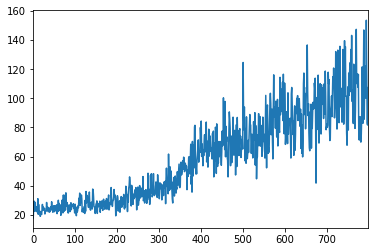

In [0]:
pd.Series(avg_returns).plot()

## Mountain Car: Non-linear function approximation and sparse rewards

### Prioritised Experience Replay

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 0  step 0  avg_returns nan  avg_loss nan  epsilon 0.0500  alpha 0.01
episode 100  step 4855  avg_returns -193.9200  avg_loss 14.2970  epsilon 0.0500  alpha 0.01
episode 200  step 9651  avg_returns -191.5600  avg_loss 2.2970  epsilon 0.0500  alpha 0.01
episode 300  step 14353  avg_returns -187.4500  avg_loss 8.0751  epsilon 0.0500  alpha 0.01
episode 400  step 19167  avg_returns -192.3500  avg_loss 24.1783  epsilon 0.0500  alpha 0.01
episode 500  step 24033  avg_returns -194.4600  avg_loss 24.9576  epsilon 0.0500  alpha 0.01
episode 600  step 28976  avg_returns -197.6700  avg_loss 39.4377  epsilon 0.0500  alpha 0.01
episode 700  step 33827  avg_returns -193.8500  avg_loss 18.4902  epsilon 0.0500  alpha 0.01
episode 800  step 38746  avg_returns -196.6000  avg_loss 8.3555  epsilon 0.0500  alpha 0.01
episode 900  step 43536  avg_returns -191.1400  avg_loss 12.3972  epsilon 0.0500  alpha 0.01
episode 1000  step 48380  avg_returns -193.5100  avg_loss 21.1567  epsilon 0.0500  alpha 0.

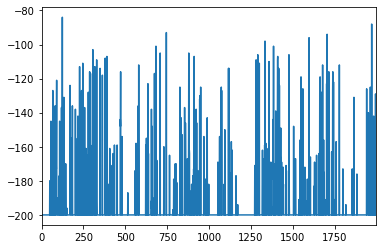

In [0]:
#%%time
# CNN seems to be too hard, try using a shallow NN using the raw state as features, the non linearaity should be able to do what the linear could not with them

# deadly triad??
# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

import gym
import random
import numpy as np
import pandas as pd
env = gym.make('MountainCar-v0')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=512): # normalise inputs?
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)        
        self.fc3 = nn.Linear(hs, hs//2)
        self.out = nn.Linear(hs//2, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc1(x)) # https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html, https://github.com/DavidSanwald/DDQNz
        x = torch.tanh(self.fc2(x)) # for reals tanh over rulu makes this thing work???
        x = torch.tanh(self.fc3(x))
        return self.out(x)

from scipy.special import softmax

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    #def push(self, *args):        
        #if len(self.memory) < self.capacity:
        #    self.memory.append([*args])
        #else:
        #    i = np.random.choice(len(self.memory), 1, p=softmax([-abs(m[-1]) for m in self.memory]))[0] # give the highest errors the lowest pr of being replaced            
        #    self.memory[i] = [*args]
    def sample(self, batch_size, prioritise):                
        #idxs = np.random.choice(len(self.memory), batch_size, p=prioritise*softmax([abs(m[-1]) for m in self.memory]) + (1-prioritise)*1/len(self.memory)) # give the highest errors more pr of being selected
        idxs = np.random.choice(len(self.memory), batch_size, p=softmax([abs(m[-1]) for m in self.memory]))# + (1-prioritise)*1/len(self.memory))
        return [self.memory[i]+[i] for i in idxs]
    def __len__(self):
        return len(self.memory)
    def update_errors(self, idxs, errors):
        for i,e in zip(idxs, errors):
            self.memory[i] = self.memory[i][:-1] + [e]

# https://colab.research.google.com/drive/13Q3nTOJY9vYbhg1C0aXXIVM-IQaVVSaU#scrollTo=x--uPzWVHWPU
q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
#optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
alpha = 0.01
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) # weight_decay == l2 reg
buffer = ReplayBuffer()
#alpha_max, alpha_min = 0.001, 0.00001
#epsilon_max, epsilon_min = 0.5, 0.1
#prioritise_max, prioritise_min = 1.0, 0.5
gamma = torch.Tensor([0.99]).cuda()
n_episodes = 2000
bs = 32
target_update, step = 1000, 0
returns, losses, xs, ys = [], [], [], []
avg_freq = 100
epsilon = 0.05
frame_skip = 4

for n in range(n_episodes):
    if n%avg_freq==0:
        avg_return = np.mean(returns[-avg_freq:])
        avg_loss = np.mean(losses[-avg_freq:])
        print('episode ' + str(n) + '  step ' + str(step) + '  avg_returns ' + format(avg_return, '.4f') + '  avg_loss ' + format(avg_loss, '.4f') + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + str(alpha))
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    #frame = 0    
    while True:
        if step%target_update==0:
            q_target.load_state_dict(q_function.state_dict())
        #print('g', g)
        #if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
        #    epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
            #prioritise = ((n_episodes/2) - n) * (prioritise_max - prioritise_min) / (n_episodes/2) + prioritise_min
        #else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
        #    epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
            #prioritise = ((n_episodes/2) - n%n_episodes) * prioritise_min / (n_episodes/2) + prioritise_min              
        
        epsilon = 0.05
        prioritise = 1.0

        #for param_group in optimiser.param_groups:
        #    param_group['lr'] = alpha
        
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0))
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values.squeeze()).item()         
    
        sub_g = 0
        for _ in range(frame_skip):
            observation, reward, done, _ = env.step(action) # repeat the action frame_skip times
            g += reward
            sub_g += reward
            if done:
                break            

        #observation, reward, done, _ = env.step(action)
        #xs.append(observation[0])
        #ys.append(observation[1])
        #reward += abs(observation[1]) # reward shaping: add velocity to the reward to encourage movement
        observation = torch.Tensor(observation).cuda()        
        
        #if (frame%frame_skip==0) or done:
        buffer.push(state, action, sub_g, observation, 1-int(done), 2) # give high error initially to ensure this sample is selected for training at least once        
        #g += reward

        #if step%frame_skip==0:
        if (len(buffer) >= bs):
            batch = buffer.sample(bs, prioritise)
            batch = [*zip(*batch)] # batch has idxs appended from the buffer
            states, actions, rewards, observations, dones, idxs = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]), torch.Tensor(batch[4]).cuda(), batch[6]            

            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1))
            #q_values_obs = q_target(observations) 
            #q_values_obs = q_function(observations) 
            #loss = F.mse_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values * dones, reduction='none') # don't reduce yet, keep losses for batch error update             
            #loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values * dones, reduction='none') # don't reduce yet, keep losses for batch error update             
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)).squeeze()                    
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * q_values_obs * dones, reduction='none') # DDQN            
            buffer.update_errors(idxs, loss.clone().detach().cpu().numpy()) # is clone required?
            loss = torch.mean(loss)
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # help with divergence
            optimiser.step()
        #frame+=1
        step+=1
        if done:
            returns.append(g)
            break
        state = observation   
        

pd.Series(returns).plot()

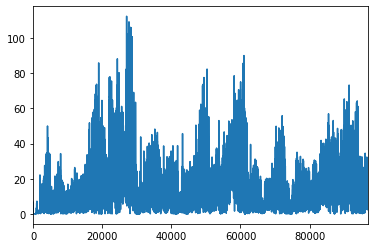

In [0]:
pd.Series(losses).plot()

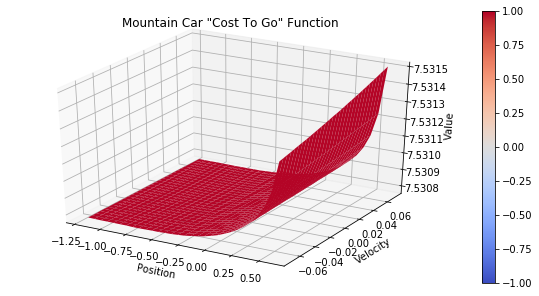

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def plot_cost_to_go_mountain_car(num_tiles=30):
    with torch.no_grad():
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
        y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
        X, Y = np.meshgrid(x, y)
        Z = np.apply_along_axis(lambda s: -np.max(q_function(torch.tensor(s).float().cuda().unsqueeze(dim=0)).cpu().squeeze().numpy()), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                          cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain Car \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()

plot_cost_to_go_mountain_car()

In [0]:
dueling DQN????????? UNSOLVED

### Cartpole: CNNs with Experience Replay, Target Networks, DDQN

In [0]:
import gym
# get frames from render in notebook
# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=RJWARWbeCUjr&forceEdit=true&sandboxMode=true
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
from gym.wrappers import Monitor
env = Monitor(gym.make("MountainCar-v0"), './video', force=True)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### Note: to disable rendering for faster training on local environments:
#### Edit rendering.py in the gym libray, insert into line 61:
#### "self.window.set_visible(visible=False)""

In [0]:
# or maybe inlucde an override method?

In [0]:
implmennt partial target update thing

In [0]:
#%%time
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
from skimage.color import rgb2gray
import gym
env = gym.make('CartPole-v1')

class DQN(nn.Module):
    def __init__(self, h=84, w=84, outputs=env.action_space.n):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(history, 16, kernel_size=5, stride=2)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        #self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        #self.bn3 = nn.BatchNorm2d(64)        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.out = nn.Linear(512, outputs)
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.out(F.relu(self.fc1(x.view(x.size(0), -1))))

class DQN(nn.Module):
    def __init__(self, h=84, w=84, outputs=env.action_space.n):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(history, 16, kernel_size=8, stride=4)
        #self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        #self.bn2 = nn.BatchNorm2d(32)      
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(w,8,4),4,2)
        convh = conv2d_size_out(conv2d_size_out(h,8,4),4,2)
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, 256)
        self.out = nn.Linear(256, outputs)
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.out(F.relu(self.fc1(x.view(x.size(0), -1))))

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=1000000):
        self.capacity = capacity//(history*2)
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)


alpha, alpha_decay, alpha_min, alpha_delay = 0.0025, 0.0004, 0.000025, 8000
epsilon, epsilon_decay, epsilon_min = 1.0, 0.0005, 0.05
target_update, targu_decay, targu_min = 2000, .0003, 100
    
gamma = torch.Tensor([0.99]).cuda()
bs = 32
n_episodes = 40000
step = 0
frame_skip = 1
history = 4
returns, avg_returns, losses = [0], [0], [0]
avg_returns_freq = 100

q_function = DQN().cuda()
q_target = DQN().cuda()
q_target.eval()
buffer = ReplayBuffer()
optimiser = torch.optim.Adam(q_function.parameters(), lr=0.0025, weight_decay=0.001) # weight_decay == l2 reg

#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

# a good post: https://rubenfiszel.github.io/posts/rl4j/2016-08-24-Reinforcement-Learning-and-DQN.html
   

print('Prefilling buffer...')
while len(buffer) < 20000:
    env.reset()
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8)         
    state = [st] * history    
    while True:        
        action = env.action_space.sample()
        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:                
                sub_g += reward
        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars
        state = observation
        if done:
            break

# one solution: https://github.com/boyuanf/DeepQLearning/blob/master/deep_q_learning.py

save_freq = 100000
epsilon_max, epsilon_min = 0.333, 0.1

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []

    """
    if n > alpha_delay:
        alpha *= 1.0 / (1 + (alpha_decay / (n_episodes-alpha_delay)) * (n-alpha_delay))
    alpha = np.clip(alpha, alpha_min, 0.0025)
    epsilon *= 1.0 / (1 + (epsilon_decay / n_episodes) * n)
    epsilon = np.clip(epsilon, epsilon_min, np.inf)
    target_update *= 1.0 / (1 + (targu_decay / n_episodes) * n)
    target_update = np.clip(target_update, targu_min, np.inf)

    for param_group in optimiser.param_groups:
        param_group['lr'] = alpha
    """
    
    if n < (n_episodes/2):
        #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
    else:
        #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
        #epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
    #alpha = 0.01
        epsilon = 0.1
    
    target_update = 100
    
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

pd.Series(returns).plot()

Prefilling buffer...
episode 0  epsilon 0.3330  alpha 0.0025  target_update 100  step 0  avg_return 0  avg_loss 0.0000
episode 100  epsilon 0.3318  alpha 0.0025  target_update 100  step 2125  avg_return 8.0  avg_loss 0.7403
episode 200  epsilon 0.3307  alpha 0.0025  target_update 100  step 4447  avg_return 20.23  avg_loss 1.9215
episode 300  epsilon 0.3295  alpha 0.0025  target_update 100  step 6683  avg_return 22.31  avg_loss 2.2957
episode 400  epsilon 0.3283  alpha 0.0025  target_update 100  step 8773  avg_return 21.2  avg_loss 2.1639
episode 500  epsilon 0.3272  alpha 0.0025  target_update 100  step 10759  avg_return 19.99  avg_loss 2.6106
episode 600  epsilon 0.3260  alpha 0.0025  target_update 100  step 12836  avg_return 18.97  avg_loss 3.0332
episode 700  epsilon 0.3248  alpha 0.0025  target_update 100  step 14949  avg_return 19.71  avg_loss 3.0733
episode 800  epsilon 0.3237  alpha 0.0025  target_update 100  step 16978  avg_return 20.19  avg_loss 2.8533
episode 900  epsilon 0.3

episode 14900  epsilon 0.1594  alpha 0.0025  target_update 100  step 419859  avg_return 62.84  avg_loss 3.7316
episode 15000  epsilon 0.1583  alpha 0.0025  target_update 100  step 425154  avg_return 57.14  avg_loss 3.1653
episode 15100  epsilon 0.1571  alpha 0.0025  target_update 100  step 430588  avg_return 52.27  avg_loss 3.0751
episode 15200  epsilon 0.1559  alpha 0.0025  target_update 100  step 436677  avg_return 53.3  avg_loss 3.2882
episode 15300  epsilon 0.1548  alpha 0.0025  target_update 100  step 442246  avg_return 59.64  avg_loss 3.1772
episode 15400  epsilon 0.1536  alpha 0.0025  target_update 100  step 446589  avg_return 55.27  avg_loss 2.9291
episode 15500  epsilon 0.1524  alpha 0.0025  target_update 100  step 450887  avg_return 41.82  avg_loss 2.5387
episode 15600  epsilon 0.1513  alpha 0.0025  target_update 100  step 455104  avg_return 42.52  avg_loss 3.1855
episode 15700  epsilon 0.1501  alpha 0.0025  target_update 100  step 458775  avg_return 40.96  avg_loss 3.6784
ep

KeyboardInterrupt: 

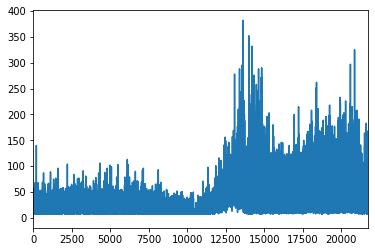

In [0]:
pd.Series(returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part1_q_function_step_' + str(step) + '.pt')

Some thoughts: 
- Initially the network must learn some general features on the CNN's filters
- This is "flat" training period where loss remains high and returns don't improve
- I used high LR, target update, and only modulate epsilon to power through this part
- Until a tippping point is hit: the CNN learns usable features and now the RL agent can learn to play the game

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.000025
epsilon = 0.1
target_update = 100
n_episodes = 5000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.1000  alpha 0.0025  target_update 100  step 800178  avg_return 52.87  avg_loss 2.5089
episode 100  epsilon 0.1000  alpha 0.0025  target_update 100  step 815334  avg_return 55.2  avg_loss 2.6021
episode 200  epsilon 0.1000  alpha 0.0025  target_update 100  step 827853  avg_return 151.01  avg_loss 2.5649
episode 300  epsilon 0.1000  alpha 0.0025  target_update 100  step 838647  avg_return 123.75  avg_loss 2.4109
episode 400  epsilon 0.1000  alpha 0.0025  target_update 100  step 849729  avg_return 106.99  avg_loss 2.2937
episode 500  epsilon 0.1000  alpha 0.0025  target_update 100  step 863037  avg_return 110.8  avg_loss 2.2412
episode 600  epsilon 0.1000  alpha 0.0025  target_update 100  step 876202  avg_return 131.44  avg_loss 2.0813
episode 700  epsilon 0.1000  alpha 0.0025  target_update 100  step 889414  avg_return 130.63  avg_loss 1.9099
episode 800  epsilon 0.1000  alpha 0.0025  target_update 100  step 900693  avg_return 130.88  avg_loss 1.6896
episode 900  eps

In [0]:
torch.save(q_function.state_dict(), './part2_q_function_step_' + str(step) + '.pt')

More Thoughts:
- Don't clear the buffer out when stopping and restarting training
- The buffer's contents are a highly valuable training resource
- A set of not useful experiences in the buffer can drive the policy away from successful games
- Above, the return plummets, preseumably because the buffer fills up with bad experiences
- To test this: Run the above again in subsequent training but turn up epsilon again to diversify experiences
- Or maybe this is instead an interaction with the decreasing loss?
- Or mabye its just growing/learning pains?

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.000001
epsilon = 0.05
target_update = 100
n_episodes = 500
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0500  alpha 0.0000  target_update 100  step 1275424  avg_return 122.19  avg_loss 1.6074
episode 100  epsilon 0.0500  alpha 0.0000  target_update 100  step 1292843  avg_return 145.07  avg_loss 1.5798
episode 200  epsilon 0.0500  alpha 0.0000  target_update 100  step 1313584  avg_return 173.91  avg_loss 1.5929
episode 300  epsilon 0.0500  alpha 0.0000  target_update 100  step 1330012  avg_return 206.83  avg_loss 1.3479
episode 400  epsilon 0.0500  alpha 0.0000  target_update 100  step 1343374  avg_return 162.87  avg_loss 1.3567


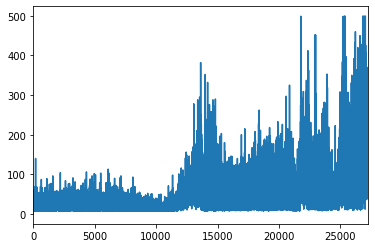

In [0]:
pd.Series(returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part3_q_function_step_' + str(step) + '.pt')

Was it just oscillating around the optimal policy previously because the learning rate was too high??
I'm surprised how much I need to lower the LR by

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.0000001
epsilon = 0.025
target_update = 100
n_episodes = 1000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0250  alpha 0.0000  target_update 100  step 1357639  avg_return 133.09  avg_loss 1.2929
episode 100  epsilon 0.0250  alpha 0.0000  target_update 100  step 1374584  avg_return 140.41  avg_loss 1.2285
episode 200  epsilon 0.0250  alpha 0.0000  target_update 100  step 1389740  avg_return 168.22  avg_loss 1.2666
episode 300  epsilon 0.0250  alpha 0.0000  target_update 100  step 1404017  avg_return 152.89  avg_loss 1.3250
episode 400  epsilon 0.0250  alpha 0.0000  target_update 100  step 1421525  avg_return 143.6  avg_loss 1.2530
episode 500  epsilon 0.0250  alpha 0.0000  target_update 100  step 1439057  avg_return 173.9  avg_loss 1.4463
episode 600  epsilon 0.0250  alpha 0.0000  target_update 100  step 1458144  avg_return 171.6  avg_loss 1.2352
episode 700  epsilon 0.0250  alpha 0.0000  target_update 100  step 1473019  avg_return 190.23  avg_loss 1.0977
episode 800  epsilon 0.0250  alpha 0.0000  target_update 100  step 1489803  avg_return 148.79  avg_loss 1.1535
episod

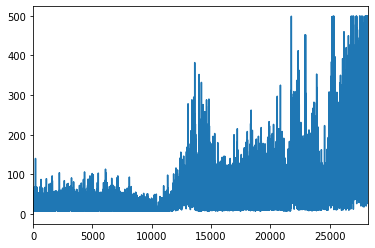

In [0]:
pd.Series(returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part4_q_function_step_' + str(step) + '.pt')

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.00000001
epsilon = 0.0125
target_update = 50
n_episodes = 1000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0125  alpha 0.0000  target_update 50  step 1534099  avg_return 232.35  avg_loss 0.9875
episode 100  epsilon 0.0125  alpha 0.0000  target_update 50  step 1557799  avg_return 207.63  avg_loss 0.8497
episode 200  epsilon 0.0125  alpha 0.0000  target_update 50  step 1578009  avg_return 236.92  avg_loss 0.8846
episode 300  epsilon 0.0125  alpha 0.0000  target_update 50  step 1599720  avg_return 200.86  avg_loss 0.9126
episode 400  epsilon 0.0125  alpha 0.0000  target_update 50  step 1619323  avg_return 215.11  avg_loss 0.7403
episode 500  epsilon 0.0125  alpha 0.0000  target_update 50  step 1638092  avg_return 194.43  avg_loss 0.8529
episode 600  epsilon 0.0125  alpha 0.0000  target_update 50  step 1655953  avg_return 187.22  avg_loss 1.0319
episode 700  epsilon 0.0125  alpha 0.0000  target_update 50  step 1675316  avg_return 177.54  avg_loss 0.8814
episode 800  epsilon 0.0125  alpha 0.0000  target_update 50  step 1694048  avg_return 192.48  avg_loss 0.8081
episode 900 

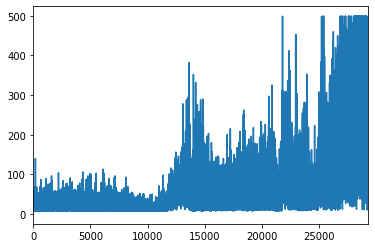

In [0]:
pd.Series(returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part5_q_function_step_' + str(step) + '.pt')

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.000000001
epsilon = 0.0125
target_update = 50
n_episodes = 1000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0125  alpha 0.0000  target_update 50  step 1726288  avg_return 163.33  avg_loss 0.9295
episode 100  epsilon 0.0125  alpha 0.0000  target_update 50  step 1746099  avg_return 157.12  avg_loss 0.9956
episode 200  epsilon 0.0125  alpha 0.0000  target_update 50  step 1767059  avg_return 201.41  avg_loss 0.8405
episode 300  epsilon 0.0125  alpha 0.0000  target_update 50  step 1785494  avg_return 205.28  avg_loss 0.8381
episode 400  epsilon 0.0125  alpha 0.0000  target_update 50  step 1802670  avg_return 183.88  avg_loss 0.8506
episode 500  epsilon 0.0125  alpha 0.0000  target_update 50  step 1819829  avg_return 169.79  avg_loss 0.9178
episode 600  epsilon 0.0125  alpha 0.0000  target_update 50  step 1837578  avg_return 169.7  avg_loss 1.0442
episode 700  epsilon 0.0125  alpha 0.0000  target_update 50  step 1853792  avg_return 177.44  avg_loss 0.8846
episode 800  epsilon 0.0125  alpha 0.0000  target_update 50  step 1871799  avg_return 160.33  avg_loss 0.7803
episode 900  

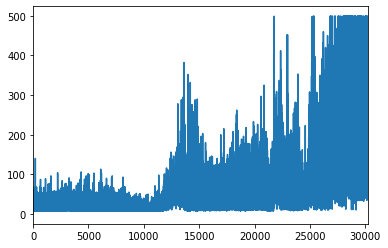

In [0]:
pd.Series(returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part6_q_function_step_' + str(step) + '.pt')

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.0000000001
epsilon = 0.01
target_update = 50
n_episodes = 1000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0100  alpha 0.0000  target_update 50  step 1912967  avg_return 211.06  avg_loss 1.0635
episode 100  epsilon 0.0100  alpha 0.0000  target_update 50  step 1932496  avg_return 195.79  avg_loss 0.9628
episode 200  epsilon 0.0100  alpha 0.0000  target_update 50  step 1949157  avg_return 192.66  avg_loss 0.8090
episode 300  epsilon 0.0100  alpha 0.0000  target_update 50  step 1969139  avg_return 168.33  avg_loss 0.7739
episode 400  epsilon 0.0100  alpha 0.0000  target_update 50  step 1988293  avg_return 196.73  avg_loss 0.8973
episode 500  epsilon 0.0100  alpha 0.0000  target_update 50  step 2008581  avg_return 190.29  avg_loss 0.9111
episode 600  epsilon 0.0100  alpha 0.0000  target_update 50  step 2025672  avg_return 202.11  avg_loss 0.8734
episode 700  epsilon 0.0100  alpha 0.0000  target_update 50  step 2044991  avg_return 169.61  avg_loss 0.8959
episode 800  epsilon 0.0100  alpha 0.0000  target_update 50  step 2063532  avg_return 191.88  avg_loss 0.8863
episode 900 

In [0]:
#filename = 'q_function_step_1909554.pt'
#step = int(filename.split('step_')[1].split('.')[0])
#q_function.load_state_dict(torch.load(filename))
#q_target.load_state_dict(torch.load(filename))

alpha = 0.0000000001
epsilon = 0.01
target_update = 100
n_episodes = 10000
optimiser = torch.optim.Adam(q_function.parameters(), lr=alpha, weight_decay=0.001) 

for n in range(n_episodes):
    env.reset()
    g = 0
    #frame = 0

    if step%save_freq==(save_freq-1):   
        torch.save(q_function.state_dict(), './q_function_step_' + str(step) + '.pt')

    # initialise state
    st = env.render(mode='rgb_array')
    st = torch.tensor(transform.resize(rgb2gray(st), (84,84)) * 255, dtype=torch.uint8) 
    #white_frame = (torch.ones((84,84)) * 255).byte()
    state = [st] * history #+ [white_frame] * (history - 1)
    observation = []
       
    if n%avg_returns_freq==0:
        ls = np.mean(losses[-avg_returns_freq:])
        print('episode ' + str(n) + '  epsilon ' + format(epsilon, '.4f') + '  alpha ' + format(alpha, '.4f') + '  target_update ' + str(int(target_update)) + '  step ' + str(step) + '  avg_return ' + str(avg_returns[-1]) + '  avg_loss ' + format(ls,'.4f'))
                
    while True: 
        
        if step%int(target_update)==0:
            #print('q_target updated')
            q_target.load_state_dict(q_function.state_dict())

        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_function((torch.stack(state).float()/255).unsqueeze(dim=0).cuda())
            action = torch.argmax(q_values[0]).item()

        sub_g = 0
        for _ in range(frame_skip):
            _, reward, done, _ = env.step(action) # repeat the action frame_skip times
            if not done:
                g += reward
                sub_g += reward

        obs = env.render(mode='rgb_array')
        obs = torch.tensor(transform.resize(rgb2gray(obs), (84,84)) * 255, dtype=torch.uint8)
        observation = [obs] + state[:-1]
        ## double pushing states is bad... oh well
        buffer.push(torch.stack(state), action, sub_g, torch.stack(observation), 1-int(done)) # sars            

        if (len(buffer) >= bs): 
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]).cuda(), torch.tensor(batch[1]).long().cuda(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]).cuda(), torch.Tensor(batch[4]).cuda()
            states = states.float()/255
            observations = observations.float()/255
            # flush cuda?
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            with torch.no_grad():
                q_values_obs = q_target(observations).gather(1, torch.argmax(q_function(observations), axis=1).view(-1,1)) # DDQN
            loss = F.smooth_l1_loss(q_values, rewards.view(-1,1) + gamma * q_values_obs * dones.view(-1,1)) # pred, targ
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            #for param in q_function.parameters():                
            #    param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        step += 1
        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        
        state = observation
        #frame += 1

episode 0  epsilon 0.0100  alpha 0.0000  target_update 100  step 2100554  avg_return 185.97  avg_loss 0.7854
episode 100  epsilon 0.0100  alpha 0.0000  target_update 100  step 2119231  avg_return 180.47  avg_loss 0.8644
episode 200  epsilon 0.0100  alpha 0.0000  target_update 100  step 2139627  avg_return 186.53  avg_loss 1.0207
episode 300  epsilon 0.0100  alpha 0.0000  target_update 100  step 2159430  avg_return 204.14  avg_loss 0.8576
episode 400  epsilon 0.0100  alpha 0.0000  target_update 100  step 2178785  avg_return 199.64  avg_loss 0.8454
episode 500  epsilon 0.0100  alpha 0.0000  target_update 100  step 2198324  avg_return 188.79  avg_loss 0.9276


MemoryError: 

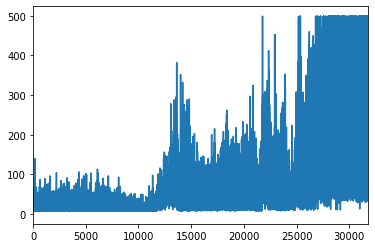

In [0]:
pd.Series(returns).plot()

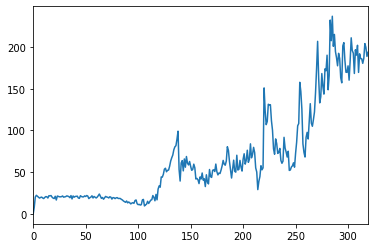

In [0]:
pd.Series(avg_returns).plot()

In [0]:
torch.save(q_function.state_dict(), './part7_q_function_step_' + str(step) + '.pt')